In [11]:
#Building the database
def build_database(db_name, csv_file_path):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS spotify_cs210 (
        name TEXT,
        artists TEXT,
        energy REAL,
        ranking REAL,
        danceability REAL,
        valence REAL,
        instrumentalness REAL,
        loudness REAL,
        duration_ms REAL,
        tempo REAL,
        country TEXT
    )
    """)

    data = pd.read_csv(csv_file_path)
    data.to_sql("spotify_cs210", conn, if_exists="replace", index=False)
    print(f"Data loaded into the database {db_name}")

    conn.commit()
    conn.close()

def read_database(db_name):
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM spotify_cs210")
    rows = cursor.fetchall()

    for row in rows:
        print(row)

    conn.close()

build_database("spotify_cs210.db", "data/Varun-Filtered.csv")
read_database("spotify_cs210.db")


Data loaded into the database spotify_cs210.db
('SLOW DANCING IN THE DARK', 'Joji', 0.4779906784049714, 1.0, 0.403485254691689, 0.2636151727060817, 0.0064718614718614, -0.1541550047126021, 0.01925908037401, -1.2072396305637123, 'US')
('I KNOW ?', 'Travis Scott', 0.6229932677369239, 0.4990892531876139, 0.9530831099195712, 0.828353464717101, 0.0, 0.8740965341441554, 0.058954855344367, -0.1227970712645307, 'US')
('Sky', 'Playboi Carti', 0.9171413775245988, 0.3321190042501518, 0.7627345844504023, 0.561347743165925, 0.0, 0.9616870696052712, -0.2566162361444148, 0.6985578626312384, 'US')
('ORANGE SODA', 'Baby Keem', 0.5660279647850854, 0.2486338797814209, 0.8230563002680964, 0.0760754397118033, 0.0, -0.2782131950155055, -1.3462205411366377, -1.3539141573080742, 'US')
('Sorry Bout That', 'Yeat', 0.6478508544795443, 0.198542805100182, 0.6890080428954424, 0.4840008476372112, 0.0, -0.2744641837700881, -0.3807257301591875, 0.7725676021830937, 'US')
('TOPIA TWINS (feat. Rob49 & 21 Savage)', 'Travi

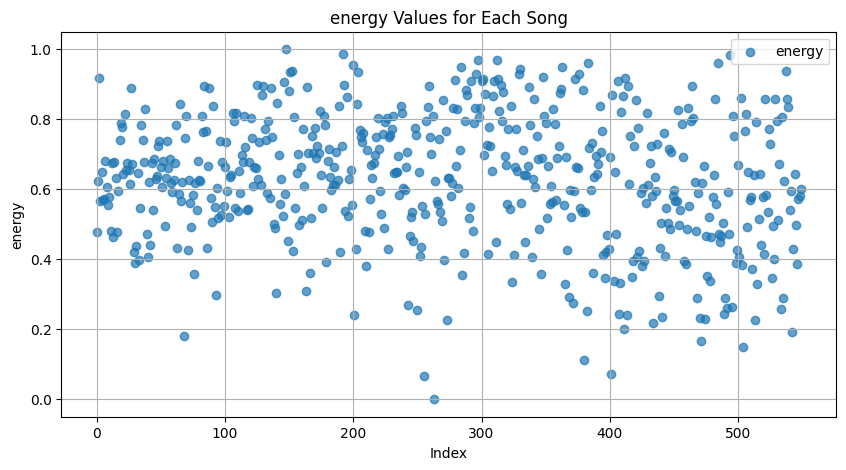

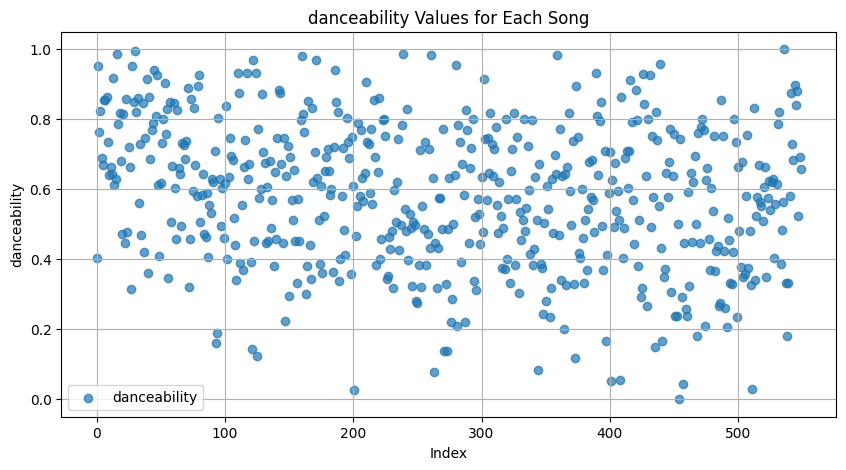

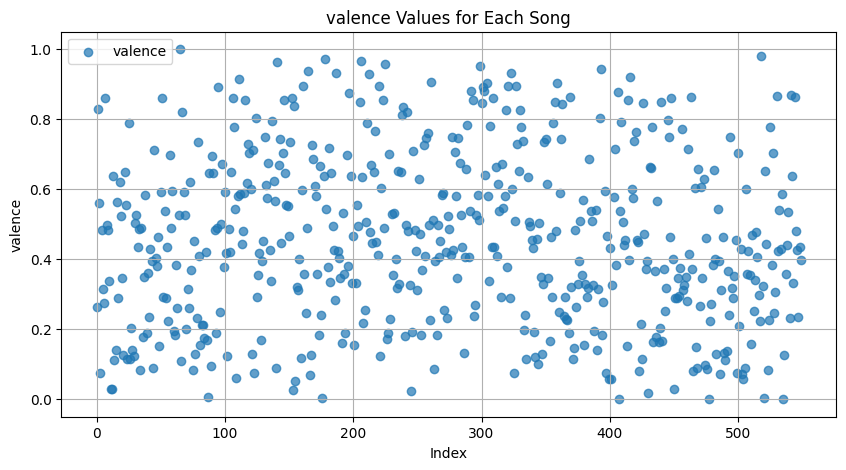

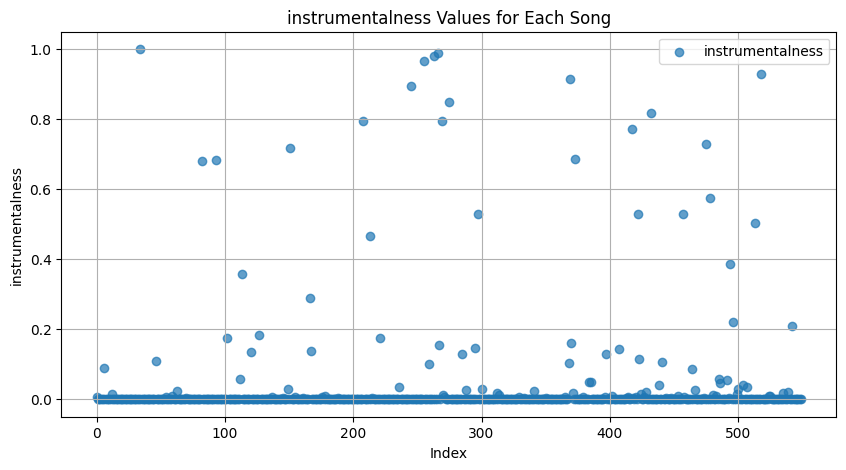

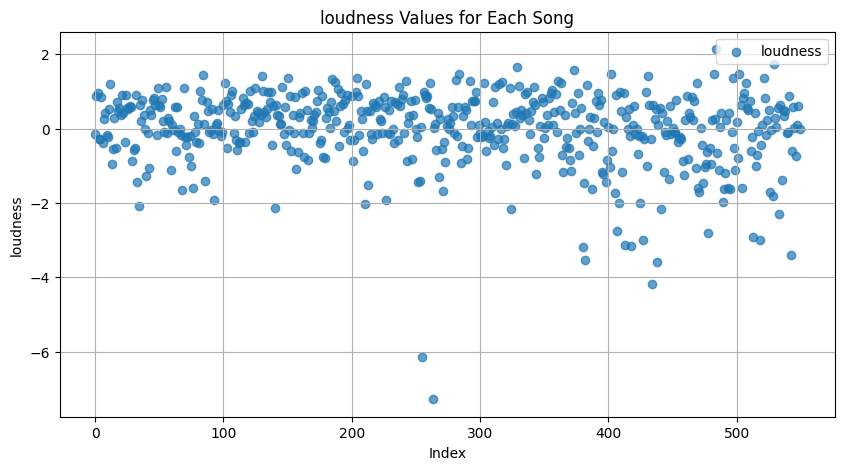

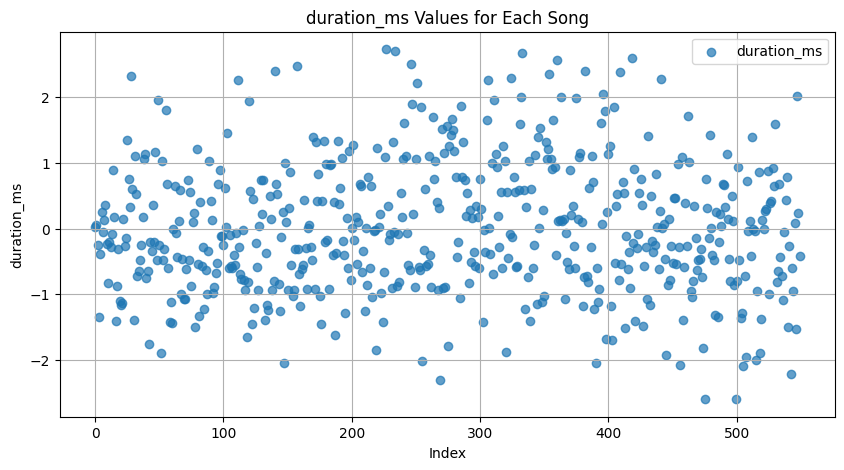

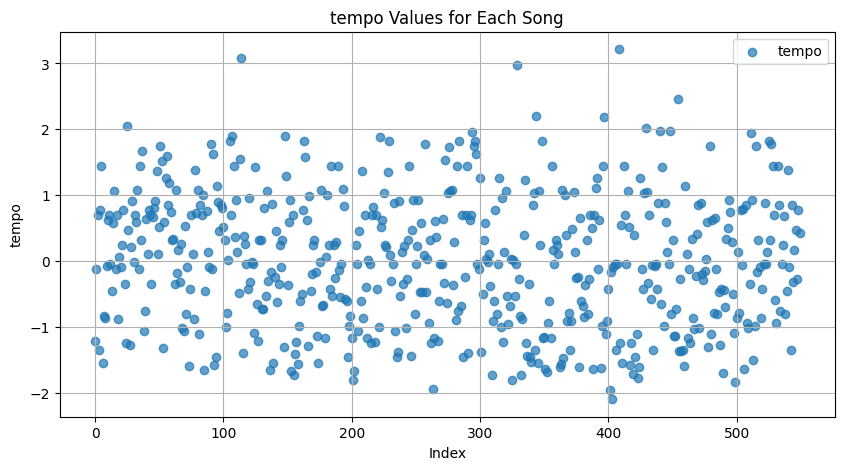

In [12]:
#Plotting the graphs
import matplotlib.pyplot as plt

db_name = "spotify_cs210.db"
conn = sqlite3.connect(db_name)

query = "SELECT energy, danceability, valence, instrumentalness, loudness, duration_ms, tempo FROM spotify_cs210"
df = pd.read_sql_query(query, conn)

conn.close()

columns_to_plot = df.columns

for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.scatter(df.index, df[column], label=column, alpha=0.7)
    plt.title(f"{column} Values for Each Song")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
#Predicting songs using NLP
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

def load_data(db_name="spotify_cs210.db"):
    conn = sqlite3.connect(db_name)
    query = "SELECT * FROM spotify_cs210"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

def train_model(data, text_column, feature_columns):
    if text_column not in data.columns:
        raise KeyError(f"The column '{text_column}' does not exist in the dataset.")

    data[text_column] = data[text_column].apply(preprocess_text)
    vectorizer = TfidfVectorizer(max_features=500)
    text_embeddings = vectorizer.fit_transform(data[text_column]).toarray()

    X_train, X_test, y_train, y_test = train_test_split(
        text_embeddings, data[feature_columns], test_size=0.2, random_state=42
    )

    models = {}
    for feature in feature_columns:
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train[feature])
        models[feature] = model

    return models, vectorizer

def predict_features(input_text, models, vectorizer):
    input_text = preprocess_text(input_text)
    input_embedding = vectorizer.transform([input_text]).toarray()
    predictions = {feature: model.predict(input_embedding)[0] for feature, model in models.items()}
    return predictions

def find_closest_songs(predicted_features, data, feature_columns, top_n=5):
    distances = euclidean_distances([list(predicted_features.values())], data[feature_columns])
    closest_indices = np.argsort(distances[0])[:top_n]
    return data.iloc[closest_indices]

data = load_data()
text_column = "name"
feature_columns = ["energy", "danceability", "valence", "instrumentalness", "loudness", "duration_ms", "tempo"]

if text_column not in data.columns:
    raise KeyError(f"The column '{text_column}' does not exist in the dataset. Available columns are: {data.columns.tolist()}")

models, vectorizer = train_model(data, text_column, feature_columns)

input_text = input("Enter a description of the song: ")
predicted_features = predict_features(input_text, models, vectorizer)
closest_songs = find_closest_songs(predicted_features, data, feature_columns)

print(f"Closest Matching Songs for '{input_text}':")
print(closest_songs)


Closest Matching Songs for 'high tempo':
                                           name  \
9          trance with travis scott  young thug   
308  mona lisa spiderman across the spiderverse   
169                      worlds smallest violin   
145                               henny in hand   
230                   cant take my eyes off you   

                                    artists    energy   ranking  danceability  \
9    Metro Boomin, Travis Scott, Young Thug  0.553599  0.098361      0.735925   
308                            Dominic Fike  0.650958  0.001421      0.727882   
169                                     AJR  0.702745  0.004072      0.621984   
145                              Tory Lanez  0.523563  0.005040      0.445040   
230                           Frankie Valli  0.773175  0.002515      0.481233   

      valence  instrumentalness  loudness  duration_ms     tempo country  
9    0.484001          0.000000 -0.176649    -0.229906 -0.067467      US  
308  0.434202  

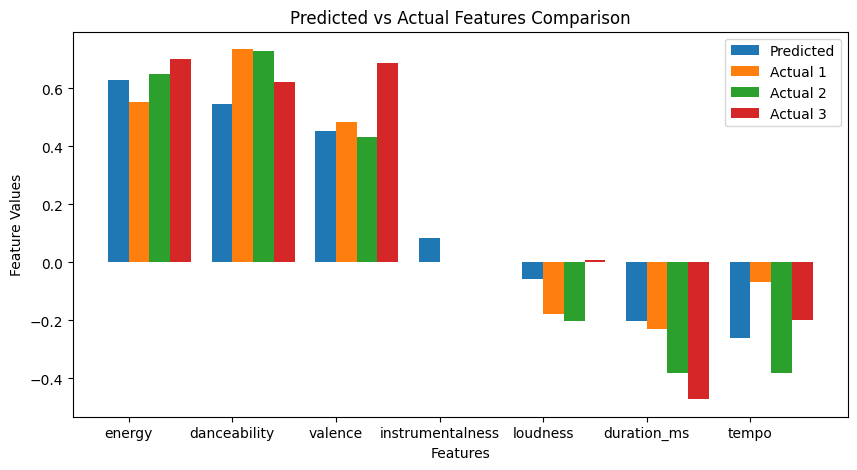

In [14]:
#Plotting actual vs predicted
import matplotlib.pyplot as plt

N = 7

closest1 = closest_songs.iloc[0]
actual1 = closest1[feature_columns].to_dict()

closest2 = closest_songs.iloc[1]
actual2 = closest2[feature_columns].to_dict()

closest3 = closest_songs.iloc[2]
actual3 = closest3[feature_columns].to_dict()

predicted_values = list(predicted_features.values())
actual_values1 = list(actual1.values())
actual_values2 = list(actual2.values())
actual_values3 = list(actual3.values())

ind = np.arange(N)

plt.figure(figsize=(10,5))

width = 0.2      

plt.bar(ind, predicted_values , width, label='Predicted')
plt.bar(ind + width, actual_values1, width, label='Actual 1')
plt.bar(ind + width*2, actual_values2, width, label='Actual 2')
plt.bar(ind + width*3, actual_values3, width, label='Actual 3')

plt.xlabel('Features')
plt.ylabel('Feature Values')
plt.title('Predicted vs Actual Features Comparison')

plt.xticks(ind + width / 2, ("energy", "danceability", "valence", "instrumentalness", "loudness", "duration_ms", "tempo"))

plt.legend(loc='best')
plt.show()